## Breast cancer detection using deep learning

In this notebook we are going to use the [Breast Histopathology Images](https://www.kaggle.com/paultimothymooney/breast-histopathology-images) dataset and the `fastai` library for detecting breast cancer. 

**Context**: 

Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to delineate the exact regions of IDC inside of a whole mount slide.

**About the dataset**:

The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). Each patch’s file name is of the format: u_xX_yY_classC.png — > example 10253_idx5_x1351_y1101_class0.png . Where u is the patient ID (10253_idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.

**Inspiration**:

Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer. Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to save time and reduce error.

Let's take a look at the class distribution of the dataset again - > 

* 198,738 negative examples (i.e., no breast cancer)
* 78,786 positive examples (i.e., indicating breast cancer was found in the patch)

0 indicates `no IDC` (no breast cancer) while 1 indicates `IDC`  (breast cancer) 

As we can see, this is a clear example of *class-imbalance*. But we will start simple and do a lot of experimentation for taking major decisions for the model training and tricking. 

In [1]:
# Get the fastai libraries and other important stuff: https://course.fast.ai/start_colab.html
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
# Authenticate Colab to use my Google Drive for data storage and retrieval
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'BreastCancer'

Mounted at /content/gdrive


In [ ]:
base_dir

'/content/gdrive/My Drive/BreastCancer'

In [ ]:
# Change the working directory
%cd /content/gdrive/My\ Drive/BreastCancer

/content/gdrive/My Drive/BreastCancer


In [ ]:
# Verify
!pwd

/content/gdrive/My Drive/BreastCancer


In [ ]:
!unzip /content/gdrive/My\ Drive/BreastCancer/IDC_regular_ps50_idx5.zip

In [3]:
!find /content/gdrive/My\ Drive/BreastCancer -maxdepth 1 -type d | wc -l

281


###  Imports

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import *

import numpy as np
np.random.seed(7)

import torch
torch.cuda.manual_seed_all(7)

import matplotlib.pyplot as ply
plt.style.use('ggplot')

### Instantiating the data augmentation object with a number of useful transforms

In [6]:
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.3, max_warp=0.3, max_rotate=20., max_zoom=0.05)
len(tfms)

2

### Loading the data in mini batches of 128 (48x48)

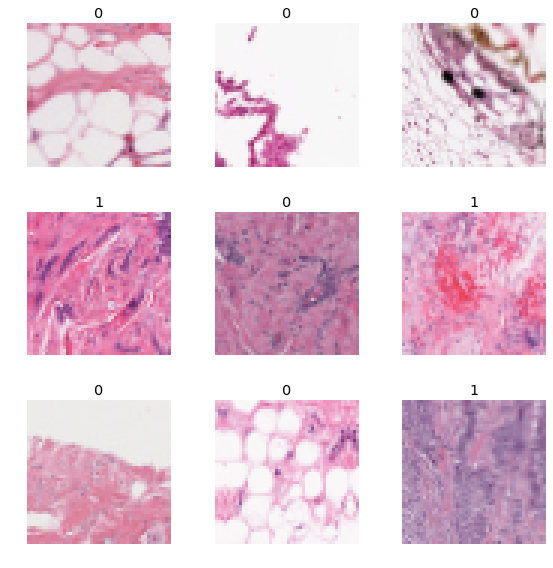

In [7]:
path = '/content/gdrive/My Drive/BreastCancer/'
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid_pct=0.2,
                                  size=48, bs=128).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(8,8))

In [8]:
# Training and validation set splits
data.label_list

LabelLists;

Train: LabelList (222020 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
0,0,0,0,0
Path: /content/gdrive/My Drive/BreastCancer;

Valid: LabelList (55504 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
0,0,0,0,0
Path: /content/gdrive/My Drive/BreastCancer;

Test: None

### Distribution of the classes in the new training and validation set

In [1]:
from collections import Counter

In [ ]:
# Training set
train_counts = Counter(data.train_ds.y)
train_counts.most_common()

In [ ]:
# Validation set
valid_counts = Counter(data.valid_ds.y)
valid_counts.most_common()

### Training a pretrained ResNet50 + Mixed precision policy

Here, we will train the last layer group a pre-trained ResNet50 model (trained on ImageNet) using mixed precision policy and 1cycle policy. We will also tweak the cross-entropy loss function so that it adds weights to the undersampled class effectively. 

In [ ]:
# Initializing the custom class weights and pop it to the GPU
from torch import nn

weights = [0.4, 1]
class_weights=torch.FloatTensor(weights).cuda()

epoch,train_loss,valid_loss,accuracy,time
0,0.400638,0.361613,0.843921,16:40
1,0.361891,0.329866,0.861596,16:15
2,0.347648,0.316130,0.858407,15:58
3,0.325453,0.307718,0.871036,16:11
4,0.330143,0.305901,0.868460,16:05


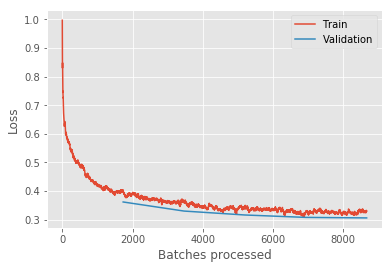

In [10]:
# Begin the training
learn = cnn_learner(data, models.resnet50, metrics=[accuracy]).to_fp16()
learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)
learn.fit_one_cycle(5);
learn.recorder.plot_losses()

In [ ]:
# Saving the model
learn.save('stage-1-rn50')

### Model's losses, accuracy scores and more

In [12]:
# Model's final validation loss and accuracy
learn.validate()

[0.30590087, tensor(0.8685)]

`tensor(0.8685)` denotes an accuracy score of **86.85%**.

In [13]:
# Model's final training loss and accuracy
learn.validate(learn.data.train_dl)

[0.31642154, tensor(0.8654)]

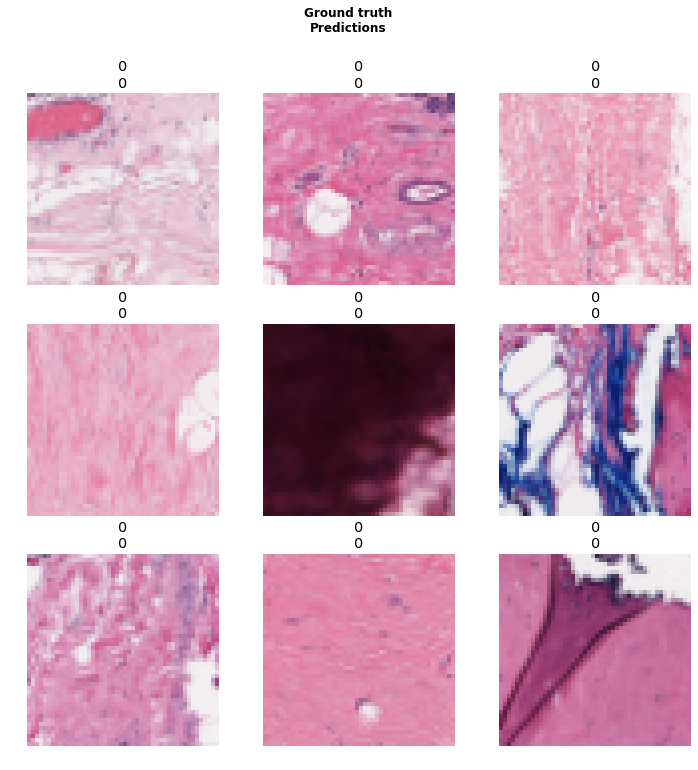

In [14]:
# Looking at model's results
learn.show_results(rows=3)

### Model's top losses and confusion matrix

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

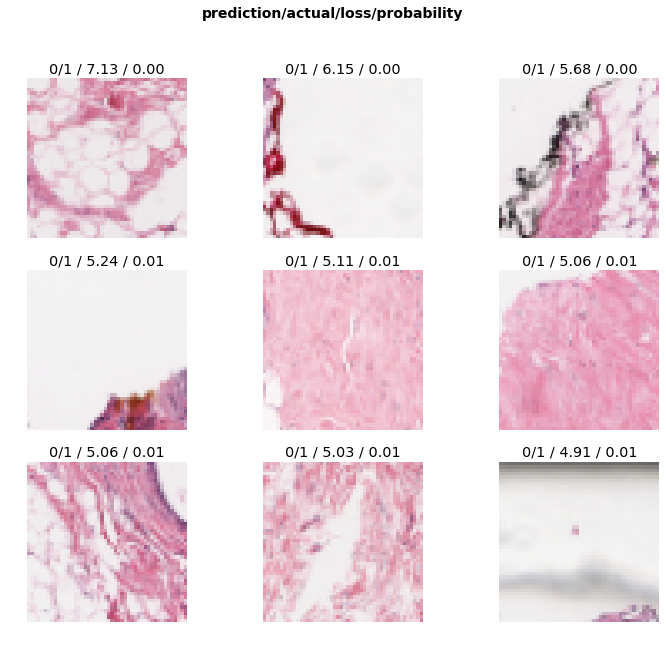

In [16]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

We can see that there are some samples which are originally IDC(+) but the model predicts them as IDC(-). **This is a staggering issue**. 

We need to be really careful with our false negative here — we don’t want to classify someone as “No cancer” when they are in fact “Cancer positive”.

Our false positive rate is also important — we don’t want to mistakenly classify someone as “Cancer positive” and then subject them to painful, expensive, and invasive treatments when they don’t actually need them.

To get a strong hold of how model is doing on false positives and false negatives, we can plot the confusion matrix. 

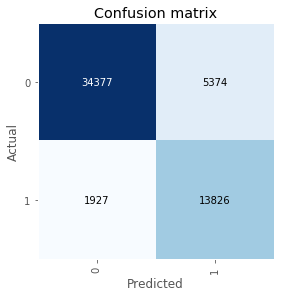

In [17]:
interp.plot_confusion_matrix()

### Classification report to look at other metrics since there is a class imbalance

In [ ]:
from sklearn.metrics import classification_report

def return_classification_report(learn):
    
    ground_truth = []
    pred_labels = []

    for i in range(len(learn.data.valid_ds)):
        temp_pred = str(learn.predict(learn.data.valid_ds[i][0])[0])
        temp_truth = str(learn.data.valid_ds[i]).split('), ', 1)[1].replace('Category ', '').replace(')', '')
        pred_labels.append(temp_pred)
        ground_truth.append(temp_truth)

    assert len(pred_labels) == len(ground_truth)
    
    return classification_report(ground_truth, pred_labels, target_names=data.classes)

In [19]:
print(return_classification_report(learn))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     39751
           1       0.72      0.88      0.79     15753

   micro avg       0.87      0.87      0.87     55504
   macro avg       0.83      0.87      0.85     55504
weighted avg       0.88      0.87      0.87     55504



![](https://i.ibb.co/bgBBFJc/Screen-Shot-2019-05-03-at-9-30-39-PM.png)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


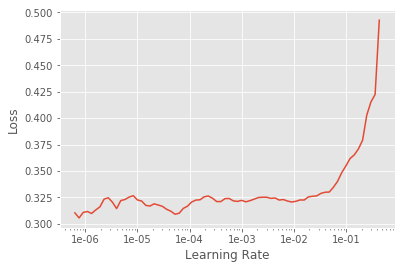

In [20]:
learn.lr_find();
learn.recorder.plot()

In [22]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-04, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.316037,0.303765,0.862983,15:40
1,0.305928,0.295346,0.866802,15:44


In [ ]:
# Save model
learn.save('stage-2-more-rn50')

In [26]:
# Looking at the classification report 
print(return_classification_report(learn))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90     39751
           1       0.71      0.90      0.79     15753

   micro avg       0.87      0.87      0.87     55504
   macro avg       0.83      0.88      0.85     55504
weighted avg       0.89      0.87      0.87     55504



### Model's architectural summary

In [27]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 24, 24]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 24, 24]         128        True      
______________________________________________________________________
ReLU                 [64, 24, 24]         0          False     
______________________________________________________________________
MaxPool2d            [64, 12, 12]         0          False     
______________________________________________________________________
Conv2d               [64, 12, 12]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 12, 12]         128        True      
______________________________________________________________________
Conv2d               [64, 12, 12]         36,864     True      
______________________________________________________________

In [ ]:
# Export the model in pickle format
learn.export('breast-cancer-rn50.pkl')

### Conclusion:

We now have a model which is **86.68%** accurate and has got a pretty **improved recall** for both in case of the +ve and the -ve classes. 

We still could have trained the network for more. We have trained it for **7 epochs** and it took *approximately* **two hours.** More fine-tuning could have been done. Sophisticated data augmentation and resolution techniques could have been applied. But let's keep them aside for further studies for now :)